In [1]:
!nvidia-smi

Sun Apr 30 03:18:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install torchsummaryX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import os
import gc
from tqdm import tqdm
import numpy as np
import scipy
from torchsummaryX import summary
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


# NIST36 Dataset

In [5]:
train_data_path = "./nist36_train.mat"
val_data_path = "./nist36_valid.mat"
test_data_path = "./nist36_test.mat"

In [6]:
class NISTDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, type="train"):
        data = scipy.io.loadmat(data_path)
        x_key, y_key = f"{type}_data", f"{type}_labels"
        self.x, self.y = data[x_key], data[y_key]

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
      return torch.from_numpy(self.x[idx]).to(torch.float32), torch.from_numpy(self.y[idx]).to(torch.float32)

In [8]:
max_iters = 50
batch_size = 128
learning_rate = 5e-3

In [9]:
train_dataset = NISTDataset(train_data_path)
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    drop_last=False, 
    num_workers=2
)


val_dataset = NISTDataset(val_data_path, type="valid")
val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    drop_last=False, 
    num_workers=2
)


test_dataset = NISTDataset(test_data_path, type="test")
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    drop_last=False, 
    num_workers=2
)

In [11]:
class MLPNet(torch.nn.Module):
  def __init__(self, input_size=1024, output_size=36):
     super(MLPNet, self).__init__()
     self.model = torch.nn.Sequential(
         torch.nn.Linear(in_features=input_size, out_features=256),
         torch.nn.Sigmoid(),
         torch.nn.Linear(in_features=256, out_features=output_size)
     )
  
  def forward(self, x):
    out = self.model(x)
    return out


In [12]:
mlpmodel = MLPNet().to(device)
imgs, labels = next(iter(train_loader))
summary(mlpmodel, imgs.to(device))

                  Kernel Shape Output Shape  Params Mult-Adds
Layer                                                        
0_model.Linear_0   [1024, 256]   [128, 256]  262.4k  262.144k
1_model.Sigmoid_1            -   [128, 256]       -         -
2_model.Linear_2     [256, 36]    [128, 36]  9.252k    9.216k
----------------------------------------------------------------
                        Totals
Total params          271.652k
Trainable params      271.652k
Non-trainable params       0.0
Mult-Adds              271.36k


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_model.Linear_0,"[1024, 256]","[128, 256]",262400.0,262144.0
1_model.Sigmoid_1,-,"[128, 256]",NaN,NaN
2_model.Linear_2,"[256, 36]","[128, 36]",9252.0,9216.0


In [13]:
torch.cuda.empty_cache()
gc.collect()

0

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlpmodel.parameters(), lr=learning_rate, momentum=0.9)

In [15]:
def train(model, optimizer, criterion, dataloader, conv=False):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    total_instances = 0
    for iter, (xb, yb) in enumerate(dataloader):
      if conv:
        xb = torch.reshape(xb, (xb.shape[0], 32, 32)).permute(0, 2, 1).unsqueeze(dim=1)
      xb = xb.to(device)
      yb = yb.to(device)
      true_labels = torch.nonzero(yb.detach(), as_tuple=True)[1]
      
      logits = model(xb)
      loss = criterion(logits, true_labels)
      
      train_loss += loss.item()
      train_acc += (torch.argmax(logits, dim=1) == true_labels).sum().item()
      
      optimizer.zero_grad()
      
      loss.backward()
      optimizer.step()

      total_instances += len(xb)

    train_loss /= len(dataloader)
    train_acc /= total_instances
    return train_loss, train_acc


def eval(model, criterion, dataloader, conv=False):
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    total_instances = 0
    with torch.inference_mode():
      for i, (xb, yb) in enumerate(dataloader):
        if conv:
          xb = torch.reshape(xb, (xb.shape[0], 32, 32)).permute(0, 2, 1).unsqueeze(dim=1)
        xb = xb.to(device)
        yb = yb.to(device)
        true_labels = torch.nonzero(yb.detach(), as_tuple=True)[1]    
        
        logits = model(xb)
        loss = criterion(logits, true_labels)
        
        val_loss += loss.item()
        val_acc += (torch.argmax(logits, dim=1) == true_labels).sum().item()
        total_instances += len(xb)

    val_loss /= len(dataloader)
    val_acc /= total_instances
    return val_loss, val_acc

In [16]:
torch.cuda.empty_cache()
best_acc = 0.0

train_losses = []
train_accs = []

val_losses = []
val_accs = []

checkpoint_path = "./mlp_model_checkpoint.pth"

for epoch in tqdm(range(max_iters)):
    train_loss, train_accuracy = train(mlpmodel, optimizer, criterion, train_loader)
    val_loss, val_accuracy = eval(mlpmodel, criterion, val_loader)
    
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print("Epoch {}/{} | Train Loss: {:.4f} | Train Accuracy: {:.2f} | Validation Accuracy: {:.2f}".format(epoch+1, max_iters, train_loss, train_accuracy, val_accuracy))
    if val_accuracy > best_acc:
      best_acc = val_accuracy
      torch.save({
          "epoch": epoch,
          "model_state_dict": mlpmodel.state_dict(),
          "optimizer_state_dict": optimizer.state_dict(),
          "loss": train_loss,
          "val_acc": val_accuracy}, checkpoint_path)


  2%|▏         | 1/50 [00:00<00:46,  1.05it/s]

Epoch 1/50 | Train Loss: 3.5817 | Train Accuracy: 0.03 | Validation Accuracy: 0.03


  4%|▍         | 2/50 [00:01<00:45,  1.06it/s]

Epoch 2/50 | Train Loss: 3.5477 | Train Accuracy: 0.06 | Validation Accuracy: 0.15


  6%|▌         | 3/50 [00:02<00:44,  1.07it/s]

Epoch 3/50 | Train Loss: 3.5094 | Train Accuracy: 0.10 | Validation Accuracy: 0.12


  8%|▊         | 4/50 [00:03<00:42,  1.08it/s]

Epoch 4/50 | Train Loss: 3.4626 | Train Accuracy: 0.18 | Validation Accuracy: 0.20


 10%|█         | 5/50 [00:04<00:41,  1.08it/s]

Epoch 5/50 | Train Loss: 3.3980 | Train Accuracy: 0.24 | Validation Accuracy: 0.23


 12%|█▏        | 6/50 [00:05<00:40,  1.09it/s]

Epoch 6/50 | Train Loss: 3.3152 | Train Accuracy: 0.31 | Validation Accuracy: 0.33


 14%|█▍        | 7/50 [00:06<00:39,  1.09it/s]

Epoch 7/50 | Train Loss: 3.2111 | Train Accuracy: 0.33 | Validation Accuracy: 0.37


 16%|█▌        | 8/50 [00:07<00:38,  1.10it/s]

Epoch 8/50 | Train Loss: 3.0875 | Train Accuracy: 0.37 | Validation Accuracy: 0.40


 18%|█▊        | 9/50 [00:08<00:36,  1.11it/s]

Epoch 9/50 | Train Loss: 2.9522 | Train Accuracy: 0.41 | Validation Accuracy: 0.39


 20%|██        | 10/50 [00:09<00:40,  1.02s/it]

Epoch 10/50 | Train Loss: 2.8115 | Train Accuracy: 0.43 | Validation Accuracy: 0.43


 22%|██▏       | 11/50 [00:10<00:43,  1.12s/it]

Epoch 11/50 | Train Loss: 2.6726 | Train Accuracy: 0.44 | Validation Accuracy: 0.44


 24%|██▍       | 12/50 [00:11<00:40,  1.06s/it]

Epoch 12/50 | Train Loss: 2.5385 | Train Accuracy: 0.46 | Validation Accuracy: 0.46


 26%|██▌       | 13/50 [00:12<00:38,  1.03s/it]

Epoch 13/50 | Train Loss: 2.4117 | Train Accuracy: 0.49 | Validation Accuracy: 0.48


 28%|██▊       | 14/50 [00:13<00:35,  1.00it/s]

Epoch 14/50 | Train Loss: 2.2945 | Train Accuracy: 0.50 | Validation Accuracy: 0.48


 30%|███       | 15/50 [00:14<00:34,  1.02it/s]

Epoch 15/50 | Train Loss: 2.1877 | Train Accuracy: 0.52 | Validation Accuracy: 0.51


 32%|███▏      | 16/50 [00:15<00:32,  1.04it/s]

Epoch 16/50 | Train Loss: 2.0902 | Train Accuracy: 0.53 | Validation Accuracy: 0.53


 34%|███▍      | 17/50 [00:16<00:31,  1.06it/s]

Epoch 17/50 | Train Loss: 2.0022 | Train Accuracy: 0.54 | Validation Accuracy: 0.54


 36%|███▌      | 18/50 [00:17<00:29,  1.07it/s]

Epoch 18/50 | Train Loss: 1.9215 | Train Accuracy: 0.56 | Validation Accuracy: 0.56


 38%|███▊      | 19/50 [00:18<00:28,  1.08it/s]

Epoch 19/50 | Train Loss: 1.8488 | Train Accuracy: 0.57 | Validation Accuracy: 0.56


 40%|████      | 20/50 [00:19<00:27,  1.08it/s]

Epoch 20/50 | Train Loss: 1.7838 | Train Accuracy: 0.58 | Validation Accuracy: 0.56


 42%|████▏     | 21/50 [00:20<00:26,  1.08it/s]

Epoch 21/50 | Train Loss: 1.7256 | Train Accuracy: 0.59 | Validation Accuracy: 0.58


 44%|████▍     | 22/50 [00:21<00:26,  1.05it/s]

Epoch 22/50 | Train Loss: 1.6731 | Train Accuracy: 0.59 | Validation Accuracy: 0.58


 46%|████▌     | 23/50 [00:22<00:29,  1.08s/it]

Epoch 23/50 | Train Loss: 1.6234 | Train Accuracy: 0.60 | Validation Accuracy: 0.59


 48%|████▊     | 24/50 [00:23<00:28,  1.11s/it]

Epoch 24/50 | Train Loss: 1.5808 | Train Accuracy: 0.61 | Validation Accuracy: 0.60


 50%|█████     | 25/50 [00:24<00:26,  1.05s/it]

Epoch 25/50 | Train Loss: 1.5405 | Train Accuracy: 0.61 | Validation Accuracy: 0.59


 52%|█████▏    | 26/50 [00:25<00:24,  1.00s/it]

Epoch 26/50 | Train Loss: 1.5073 | Train Accuracy: 0.62 | Validation Accuracy: 0.61


 54%|█████▍    | 27/50 [00:26<00:22,  1.02it/s]

Epoch 27/50 | Train Loss: 1.4728 | Train Accuracy: 0.62 | Validation Accuracy: 0.60


 56%|█████▌    | 28/50 [00:27<00:20,  1.05it/s]

Epoch 28/50 | Train Loss: 1.4444 | Train Accuracy: 0.63 | Validation Accuracy: 0.62


 58%|█████▊    | 29/50 [00:28<00:19,  1.07it/s]

Epoch 29/50 | Train Loss: 1.4158 | Train Accuracy: 0.64 | Validation Accuracy: 0.61


 60%|██████    | 30/50 [00:29<00:18,  1.08it/s]

Epoch 30/50 | Train Loss: 1.3920 | Train Accuracy: 0.64 | Validation Accuracy: 0.62


 62%|██████▏   | 31/50 [00:30<00:17,  1.08it/s]

Epoch 31/50 | Train Loss: 1.3652 | Train Accuracy: 0.65 | Validation Accuracy: 0.63


 64%|██████▍   | 32/50 [00:30<00:16,  1.09it/s]

Epoch 32/50 | Train Loss: 1.3445 | Train Accuracy: 0.65 | Validation Accuracy: 0.63


 66%|██████▌   | 33/50 [00:31<00:15,  1.08it/s]

Epoch 33/50 | Train Loss: 1.3249 | Train Accuracy: 0.65 | Validation Accuracy: 0.63


 68%|██████▊   | 34/50 [00:32<00:14,  1.08it/s]

Epoch 34/50 | Train Loss: 1.3046 | Train Accuracy: 0.65 | Validation Accuracy: 0.63


 70%|███████   | 35/50 [00:33<00:15,  1.00s/it]

Epoch 35/50 | Train Loss: 1.2901 | Train Accuracy: 0.66 | Validation Accuracy: 0.64


 72%|███████▏  | 36/50 [00:35<00:16,  1.17s/it]

Epoch 36/50 | Train Loss: 1.2726 | Train Accuracy: 0.66 | Validation Accuracy: 0.65


 74%|███████▍  | 37/50 [00:37<00:16,  1.28s/it]

Epoch 37/50 | Train Loss: 1.2579 | Train Accuracy: 0.66 | Validation Accuracy: 0.65


 76%|███████▌  | 38/50 [00:38<00:15,  1.26s/it]

Epoch 38/50 | Train Loss: 1.2403 | Train Accuracy: 0.67 | Validation Accuracy: 0.64


 78%|███████▊  | 39/50 [00:39<00:12,  1.16s/it]

Epoch 39/50 | Train Loss: 1.2230 | Train Accuracy: 0.67 | Validation Accuracy: 0.65


 80%|████████  | 40/50 [00:40<00:10,  1.09s/it]

Epoch 40/50 | Train Loss: 1.2144 | Train Accuracy: 0.67 | Validation Accuracy: 0.65


 82%|████████▏ | 41/50 [00:41<00:09,  1.03s/it]

Epoch 41/50 | Train Loss: 1.2024 | Train Accuracy: 0.68 | Validation Accuracy: 0.65


 84%|████████▍ | 42/50 [00:41<00:07,  1.01it/s]

Epoch 42/50 | Train Loss: 1.1913 | Train Accuracy: 0.68 | Validation Accuracy: 0.66


 86%|████████▌ | 43/50 [00:42<00:06,  1.03it/s]

Epoch 43/50 | Train Loss: 1.1764 | Train Accuracy: 0.68 | Validation Accuracy: 0.66


 88%|████████▊ | 44/50 [00:43<00:05,  1.04it/s]

Epoch 44/50 | Train Loss: 1.1684 | Train Accuracy: 0.68 | Validation Accuracy: 0.66


 90%|█████████ | 45/50 [00:44<00:04,  1.04it/s]

Epoch 45/50 | Train Loss: 1.1552 | Train Accuracy: 0.69 | Validation Accuracy: 0.66


 92%|█████████▏| 46/50 [00:45<00:03,  1.05it/s]

Epoch 46/50 | Train Loss: 1.1468 | Train Accuracy: 0.69 | Validation Accuracy: 0.67


 94%|█████████▍| 47/50 [00:46<00:02,  1.06it/s]

Epoch 47/50 | Train Loss: 1.1353 | Train Accuracy: 0.69 | Validation Accuracy: 0.67


 96%|█████████▌| 48/50 [00:47<00:02,  1.01s/it]

Epoch 48/50 | Train Loss: 1.1291 | Train Accuracy: 0.69 | Validation Accuracy: 0.67


 98%|█████████▊| 49/50 [00:49<00:01,  1.37s/it]

Epoch 49/50 | Train Loss: 1.1193 | Train Accuracy: 0.70 | Validation Accuracy: 0.68


100%|██████████| 50/50 [00:51<00:00,  1.04s/it]

Epoch 50/50 | Train Loss: 1.1107 | Train Accuracy: 0.70 | Validation Accuracy: 0.68


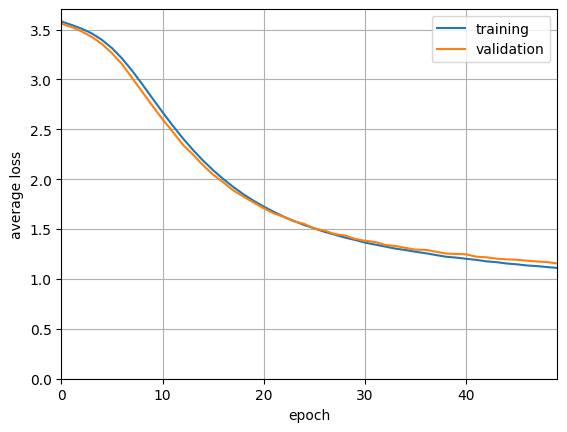

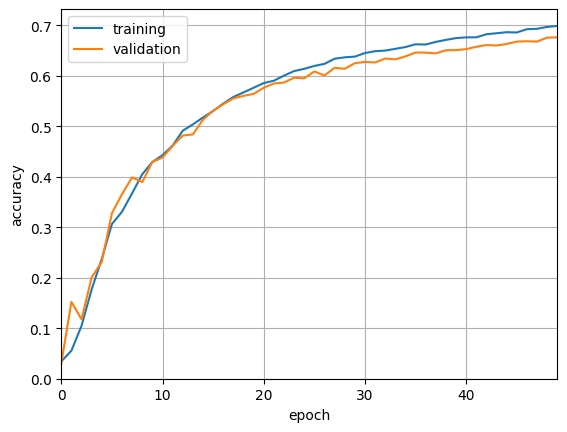

In [17]:
# plot loss curves
plt.plot(range(len(train_losses)), train_losses, label="training")
plt.plot(range(len(val_losses)), val_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("average loss")
plt.xlim(0, len(train_losses) - 1)
plt.ylim(0, None)
plt.legend()
plt.grid()
plt.show()

# plot accuracy curves
plt.plot(range(len(train_accs)), train_accs, label="training")
plt.plot(range(len(val_accs)), val_accs, label="validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xlim(0, len(train_accs) - 1)
plt.ylim(0, None)
plt.legend()
plt.grid()
plt.show()

In [18]:
model = MLPNet().to(device)
model_state_dict_path = torch.load(checkpoint_path)
model.load_state_dict(model_state_dict_path["model_state_dict"])

<All keys matched successfully>

In [19]:
_, test_accuracy = eval(model, criterion, test_loader)
print("MLP Net NIST Test Accuracy: {:.2f}%".format(test_accuracy))

MLP Net NIST Test Accuracy: 0.69%


In [ ]:
torch.cuda.empty_cache()
gc.collect()

7062

In [ ]:
class ConvNet(torch.nn.Module):
  def __init__(self, in_channels=1, output_size=36):
     super(ConvNet, self).__init__()
     self.backbone = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=2, padding=3),
        torch.nn.BatchNorm2d(64),
        torch.nn.GELU(),
        torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=3),
        torch.nn.BatchNorm2d(128),
        torch.nn.GELU()
      )
     self.head = torch.nn.Sequential(
         torch.nn.Flatten(),
         torch.nn.Linear(in_features=128*10*10, out_features=128),
         torch.nn.BatchNorm1d(num_features=128),
         torch.nn.GELU(),
         torch.nn.Dropout(p=0.2),
         torch.nn.Linear(in_features=128, out_features=output_size)
     )
  
  def forward(self, x):
    embedding = self.backbone(x)
    out = self.head(embedding)
    return out


In [ ]:
convmodel = ConvNet().to(device)
imgs, labels = next(iter(train_loader))
imgs = torch.reshape(imgs, (imgs.shape[0], 32, 32)).permute(0, 2, 1).unsqueeze(dim=1)
summary(convmodel, imgs.to(device))

                             Kernel Shape        Output Shape     Params  \
Layer                                                                      
0_backbone.Conv2d_0         [1, 64, 3, 3]   [128, 64, 18, 18]      640.0   
1_backbone.BatchNorm2d_1             [64]   [128, 64, 18, 18]      128.0   
2_backbone.GELU_2                       -   [128, 64, 18, 18]          -   
3_backbone.Conv2d_3       [64, 128, 5, 5]  [128, 128, 10, 10]   204.928k   
4_backbone.BatchNorm2d_4            [128]  [128, 128, 10, 10]      256.0   
5_backbone.GELU_5                       -  [128, 128, 10, 10]          -   
6_head.Flatten_0                        -        [128, 12800]          -   
7_head.Linear_1              [12800, 128]          [128, 128]  1.638528M   
8_head.BatchNorm1d_2                [128]          [128, 128]      256.0   
9_head.GELU_3                           -          [128, 128]          -   
10_head.Dropout_4                       -          [128, 128]          -   
11_head.Line

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_backbone.Conv2d_0,"[1, 64, 3, 3]","[128, 64, 18, 18]",640.0,186624.0
1_backbone.BatchNorm2d_1,[64],"[128, 64, 18, 18]",128.0,64.0
2_backbone.GELU_2,-,"[128, 64, 18, 18]",NaN,NaN
3_backbone.Conv2d_3,"[64, 128, 5, 5]","[128, 128, 10, 10]",204928.0,20480000.0
4_backbone.BatchNorm2d_4,[128],"[128, 128, 10, 10]",256.0,128.0
5_backbone.GELU_5,-,"[128, 128, 10, 10]",NaN,NaN
6_head.Flatten_0,-,"[128, 12800]",NaN,NaN
7_head.Linear_1,"[12800, 128]","[128, 128]",1638528.0,1638400.0
8_head.BatchNorm1d_2,[128],"[128, 128]",256.0,128.0


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(convmodel.parameters(), lr=learning_rate, weight_decay=0.01,)

In [ ]:
torch.cuda.empty_cache()
best_acc = 0.0

train_losses = []
train_accs = []

val_losses = []
val_accs = []

checkpoint_path = "./conv_model_checkpoint.pth"

for epoch in tqdm(range(max_iters)):
    train_loss, train_accuracy = train(convmodel, optimizer, criterion, train_loader, conv=True)
    val_loss, val_accuracy = eval(convmodel, criterion, val_loader, conv=True)
    
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print("Epoch {}/{} | Train Loss: {:.4f} | Train Accuracy: {:.2f} | Validation Accuracy: {:.2f}".format(epoch+1, max_iters, train_loss, train_accuracy, val_accuracy))
    if val_accuracy > best_acc:
      best_acc = val_accuracy
      torch.save({
          "epoch": epoch,
          "model_state_dict": convmodel.state_dict(),
          "optimizer_state_dict": optimizer.state_dict(),
          "loss": train_loss,
          "val_acc": val_accuracy}, checkpoint_path)


  2%|▏         | 1/50 [00:01<01:17,  1.57s/it]

Epoch 1/50 | Train Loss: 1.1308 | Train Accuracy: 0.71 | Validation Accuracy: 0.84


  4%|▍         | 2/50 [00:03<01:12,  1.51s/it]

Epoch 2/50 | Train Loss: 0.3421 | Train Accuracy: 0.90 | Validation Accuracy: 0.86


  6%|▌         | 3/50 [00:04<01:09,  1.48s/it]

Epoch 3/50 | Train Loss: 0.2067 | Train Accuracy: 0.94 | Validation Accuracy: 0.86


  8%|▊         | 4/50 [00:06<01:12,  1.58s/it]

Epoch 4/50 | Train Loss: 0.1379 | Train Accuracy: 0.96 | Validation Accuracy: 0.87


 10%|█         | 5/50 [00:08<01:18,  1.74s/it]

Epoch 5/50 | Train Loss: 0.0982 | Train Accuracy: 0.97 | Validation Accuracy: 0.88


 12%|█▏        | 6/50 [00:09<01:12,  1.65s/it]

Epoch 6/50 | Train Loss: 0.0741 | Train Accuracy: 0.98 | Validation Accuracy: 0.89


 14%|█▍        | 7/50 [00:11<01:08,  1.58s/it]

Epoch 7/50 | Train Loss: 0.0543 | Train Accuracy: 0.98 | Validation Accuracy: 0.90


 16%|█▌        | 8/50 [00:12<01:04,  1.52s/it]

Epoch 8/50 | Train Loss: 0.0414 | Train Accuracy: 0.99 | Validation Accuracy: 0.85


 18%|█▊        | 9/50 [00:14<01:01,  1.50s/it]

Epoch 9/50 | Train Loss: 0.0316 | Train Accuracy: 0.99 | Validation Accuracy: 0.88


 20%|██        | 10/50 [00:15<00:59,  1.48s/it]

Epoch 10/50 | Train Loss: 0.0382 | Train Accuracy: 0.99 | Validation Accuracy: 0.89


 22%|██▏       | 11/50 [00:16<00:56,  1.45s/it]

Epoch 11/50 | Train Loss: 0.0291 | Train Accuracy: 0.99 | Validation Accuracy: 0.90


 24%|██▍       | 12/50 [00:18<00:54,  1.43s/it]

Epoch 12/50 | Train Loss: 0.0247 | Train Accuracy: 0.99 | Validation Accuracy: 0.90


 26%|██▌       | 13/50 [00:20<00:59,  1.61s/it]

Epoch 13/50 | Train Loss: 0.0251 | Train Accuracy: 0.99 | Validation Accuracy: 0.90


 28%|██▊       | 14/50 [00:21<00:57,  1.60s/it]

Epoch 14/50 | Train Loss: 0.0210 | Train Accuracy: 0.99 | Validation Accuracy: 0.87


 30%|███       | 15/50 [00:23<00:53,  1.54s/it]

Epoch 15/50 | Train Loss: 0.0162 | Train Accuracy: 1.00 | Validation Accuracy: 0.88


 32%|███▏      | 16/50 [00:24<00:50,  1.49s/it]

Epoch 16/50 | Train Loss: 0.0158 | Train Accuracy: 1.00 | Validation Accuracy: 0.89


 34%|███▍      | 17/50 [00:25<00:48,  1.46s/it]

Epoch 17/50 | Train Loss: 0.0175 | Train Accuracy: 1.00 | Validation Accuracy: 0.85


 36%|███▌      | 18/50 [00:27<00:45,  1.44s/it]

Epoch 18/50 | Train Loss: 0.0265 | Train Accuracy: 0.99 | Validation Accuracy: 0.86


 38%|███▊      | 19/50 [00:28<00:44,  1.43s/it]

Epoch 19/50 | Train Loss: 0.0328 | Train Accuracy: 0.99 | Validation Accuracy: 0.77


 40%|████      | 20/50 [00:30<00:42,  1.42s/it]

Epoch 20/50 | Train Loss: 0.0301 | Train Accuracy: 0.99 | Validation Accuracy: 0.89


 42%|████▏     | 21/50 [00:31<00:43,  1.51s/it]

Epoch 21/50 | Train Loss: 0.0263 | Train Accuracy: 0.99 | Validation Accuracy: 0.90


 44%|████▍     | 22/50 [00:33<00:45,  1.63s/it]

Epoch 22/50 | Train Loss: 0.0188 | Train Accuracy: 0.99 | Validation Accuracy: 0.88


 46%|████▌     | 23/50 [00:35<00:42,  1.57s/it]

Epoch 23/50 | Train Loss: 0.0141 | Train Accuracy: 1.00 | Validation Accuracy: 0.87


 48%|████▊     | 24/50 [00:36<00:39,  1.52s/it]

Epoch 24/50 | Train Loss: 0.0127 | Train Accuracy: 1.00 | Validation Accuracy: 0.90


 50%|█████     | 25/50 [00:38<00:37,  1.49s/it]

Epoch 25/50 | Train Loss: 0.0118 | Train Accuracy: 1.00 | Validation Accuracy: 0.91


 52%|█████▏    | 26/50 [00:39<00:35,  1.46s/it]

Epoch 26/50 | Train Loss: 0.0081 | Train Accuracy: 1.00 | Validation Accuracy: 0.91


 54%|█████▍    | 27/50 [00:40<00:33,  1.45s/it]

Epoch 27/50 | Train Loss: 0.0041 | Train Accuracy: 1.00 | Validation Accuracy: 0.91


 56%|█████▌    | 28/50 [00:42<00:31,  1.43s/it]

Epoch 28/50 | Train Loss: 0.0035 | Train Accuracy: 1.00 | Validation Accuracy: 0.91


 58%|█████▊    | 29/50 [00:43<00:30,  1.43s/it]

Epoch 29/50 | Train Loss: 0.0047 | Train Accuracy: 1.00 | Validation Accuracy: 0.91


 60%|██████    | 30/50 [00:45<00:32,  1.62s/it]

Epoch 30/50 | Train Loss: 0.0059 | Train Accuracy: 1.00 | Validation Accuracy: 0.88


 62%|██████▏   | 31/50 [00:47<00:30,  1.61s/it]

Epoch 31/50 | Train Loss: 0.0090 | Train Accuracy: 1.00 | Validation Accuracy: 0.87


 64%|██████▍   | 32/50 [00:48<00:27,  1.55s/it]

Epoch 32/50 | Train Loss: 0.0213 | Train Accuracy: 0.99 | Validation Accuracy: 0.85


 66%|██████▌   | 33/50 [00:50<00:25,  1.51s/it]

Epoch 33/50 | Train Loss: 0.0229 | Train Accuracy: 0.99 | Validation Accuracy: 0.82


 68%|██████▊   | 34/50 [00:51<00:23,  1.48s/it]

Epoch 34/50 | Train Loss: 0.0251 | Train Accuracy: 0.99 | Validation Accuracy: 0.85


 70%|███████   | 35/50 [00:52<00:21,  1.45s/it]

Epoch 35/50 | Train Loss: 0.0200 | Train Accuracy: 0.99 | Validation Accuracy: 0.89


 72%|███████▏  | 36/50 [00:54<00:20,  1.44s/it]

Epoch 36/50 | Train Loss: 0.0198 | Train Accuracy: 0.99 | Validation Accuracy: 0.84


 74%|███████▍  | 37/50 [00:55<00:18,  1.43s/it]

Epoch 37/50 | Train Loss: 0.0189 | Train Accuracy: 0.99 | Validation Accuracy: 0.89


 76%|███████▌  | 38/50 [00:57<00:18,  1.55s/it]

Epoch 38/50 | Train Loss: 0.0202 | Train Accuracy: 0.99 | Validation Accuracy: 0.89


 78%|███████▊  | 39/50 [00:59<00:17,  1.63s/it]

Epoch 39/50 | Train Loss: 0.0132 | Train Accuracy: 1.00 | Validation Accuracy: 0.90


 80%|████████  | 40/50 [01:00<00:15,  1.56s/it]

Epoch 40/50 | Train Loss: 0.0061 | Train Accuracy: 1.00 | Validation Accuracy: 0.91


 82%|████████▏ | 41/50 [01:02<00:13,  1.50s/it]

Epoch 41/50 | Train Loss: 0.0034 | Train Accuracy: 1.00 | Validation Accuracy: 0.91


 84%|████████▍ | 42/50 [01:03<00:11,  1.46s/it]

Epoch 42/50 | Train Loss: 0.0059 | Train Accuracy: 1.00 | Validation Accuracy: 0.90


 86%|████████▌ | 43/50 [01:04<00:10,  1.44s/it]

Epoch 43/50 | Train Loss: 0.0073 | Train Accuracy: 1.00 | Validation Accuracy: 0.90


 88%|████████▊ | 44/50 [01:06<00:08,  1.42s/it]

Epoch 44/50 | Train Loss: 0.0094 | Train Accuracy: 1.00 | Validation Accuracy: 0.89


 90%|█████████ | 45/50 [01:07<00:07,  1.41s/it]

Epoch 45/50 | Train Loss: 0.0176 | Train Accuracy: 0.99 | Validation Accuracy: 0.90


 92%|█████████▏| 46/50 [01:09<00:05,  1.42s/it]

Epoch 46/50 | Train Loss: 0.0095 | Train Accuracy: 1.00 | Validation Accuracy: 0.89


 94%|█████████▍| 47/50 [01:11<00:04,  1.60s/it]

Epoch 47/50 | Train Loss: 0.0144 | Train Accuracy: 1.00 | Validation Accuracy: 0.86


 96%|█████████▌| 48/50 [01:12<00:03,  1.59s/it]

Epoch 48/50 | Train Loss: 0.0121 | Train Accuracy: 1.00 | Validation Accuracy: 0.88


 98%|█████████▊| 49/50 [01:14<00:01,  1.53s/it]

Epoch 49/50 | Train Loss: 0.0061 | Train Accuracy: 1.00 | Validation Accuracy: 0.90


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]

Epoch 50/50 | Train Loss: 0.0038 | Train Accuracy: 1.00 | Validation Accuracy: 0.92


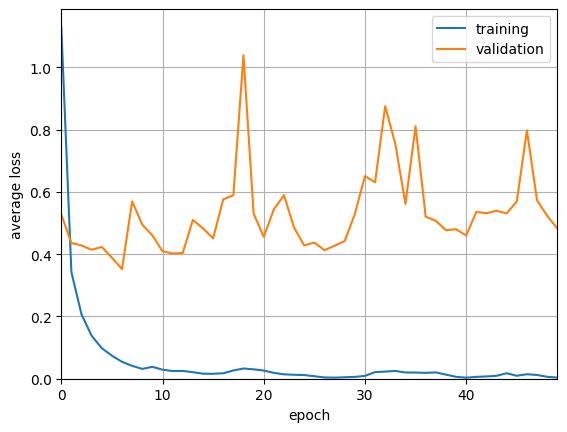

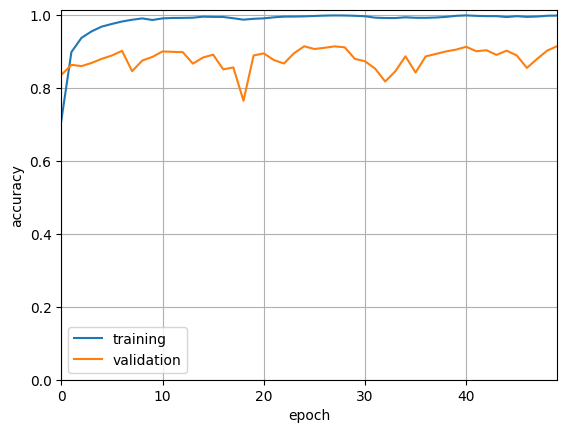

In [ ]:
# plot loss curves
plt.plot(range(len(train_losses)), train_losses, label="training")
plt.plot(range(len(val_losses)), val_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("average loss")
plt.xlim(0, len(train_losses) - 1)
plt.ylim(0, None)
plt.legend()
plt.grid()
plt.show()

# plot accuracy curves
plt.plot(range(len(train_accs)), train_accs, label="training")
plt.plot(range(len(val_accs)), val_accs, label="validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xlim(0, len(train_accs) - 1)
plt.ylim(0, None)
plt.legend()
plt.grid()
plt.show()

In [ ]:
model = ConvNet().to(device)
model_state_dict_path = torch.load(checkpoint_path)
model.load_state_dict(model_state_dict_path["model_state_dict"])

<All keys matched successfully>

In [ ]:
_, test_accuracy = eval(model, criterion, test_loader, conv=True)
print("Conv Net NIST Test Accuracy: {:.2f}%".format(test_accuracy))

Conv Net NIST Test Accuracy: 0.91%


# CIFAR10 Dataset

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_trainset = torchvision.datasets.CIFAR10(root='./cifardata', train=True,
                                        download=True, transform=transform)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

cifar_testset = torchvision.datasets.CIFAR10(root='./cifardata', train=False,
                                       download=True, transform=transform)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:07<00:00, 22779702.53it/s]


Extracting ./cifardata/cifar-10-python.tar.gz to ./cifardata
Files already downloaded and verified


In [ ]:
cifarmodel = ConvNet(in_channels=3, output_size=10).to(device)
imgs, labels = next(iter(cifar_trainloader))
summary(cifarmodel, imgs.to(device))

                             Kernel Shape        Output Shape     Params  \
Layer                                                                      
0_backbone.Conv2d_0         [3, 64, 3, 3]   [128, 64, 18, 18]     1.792k   
1_backbone.BatchNorm2d_1             [64]   [128, 64, 18, 18]      128.0   
2_backbone.GELU_2                       -   [128, 64, 18, 18]          -   
3_backbone.Conv2d_3       [64, 128, 5, 5]  [128, 128, 10, 10]   204.928k   
4_backbone.BatchNorm2d_4            [128]  [128, 128, 10, 10]      256.0   
5_backbone.GELU_5                       -  [128, 128, 10, 10]          -   
6_head.Flatten_0                        -        [128, 12800]          -   
7_head.Linear_1              [12800, 128]          [128, 128]  1.638528M   
8_head.BatchNorm1d_2                [128]          [128, 128]      256.0   
9_head.GELU_3                           -          [128, 128]          -   
10_head.Dropout_4                       -          [128, 128]          -   
11_head.Line

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_backbone.Conv2d_0,"[3, 64, 3, 3]","[128, 64, 18, 18]",1792.0,559872.0
1_backbone.BatchNorm2d_1,[64],"[128, 64, 18, 18]",128.0,64.0
2_backbone.GELU_2,-,"[128, 64, 18, 18]",NaN,NaN
3_backbone.Conv2d_3,"[64, 128, 5, 5]","[128, 128, 10, 10]",204928.0,20480000.0
4_backbone.BatchNorm2d_4,[128],"[128, 128, 10, 10]",256.0,128.0
5_backbone.GELU_5,-,"[128, 128, 10, 10]",NaN,NaN
6_head.Flatten_0,-,"[128, 12800]",NaN,NaN
7_head.Linear_1,"[12800, 128]","[128, 128]",1638528.0,1638400.0
8_head.BatchNorm1d_2,[128],"[128, 128]",256.0,128.0


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cifarmodel.parameters(), lr=learning_rate, weight_decay=0.01,)

In [ ]:
def traincifar(model, optimizer, criterion, dataloader):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    total_instances = 0
    for iter, (xb, yb) in enumerate(dataloader):
      xb = xb.to(device)
      yb = yb.to(device)
      
      logits = model(xb)
      loss = criterion(logits, yb)
      
      train_loss += loss.item()
      train_acc += (torch.argmax(logits, dim=1) == yb).sum().item()
      
      optimizer.zero_grad()
      
      loss.backward()
      optimizer.step()

      total_instances += len(xb)

    train_loss /= len(dataloader)
    train_acc /= total_instances
    return train_loss, train_acc

In [ ]:
torch.cuda.empty_cache()
best_acc = 0.0

train_losses = []
train_accs = []

checkpoint_path = "./cifar_model_checkpoint.pth"
max_iters = 10

for epoch in tqdm(range(max_iters)):
    train_loss, train_accuracy = traincifar(cifarmodel, optimizer, criterion, cifar_trainloader)

    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print("Epoch {}/{} | Train Loss: {:.4f} | Train Accuracy: {:.2f}".format(epoch+1, max_iters, train_loss, train_accuracy))
    if train_accuracy > best_acc:
      best_acc = train_accuracy
      torch.save({
          "epoch": epoch,
          "model_state_dict": cifarmodel.state_dict(),
          "optimizer_state_dict": optimizer.state_dict(),
          "loss": train_loss,
          "val_acc": train_accuracy}, checkpoint_path)


 10%|█         | 1/10 [00:16<02:27, 16.43s/it]

Epoch 1/10 | Train Loss: 1.2928 | Train Accuracy: 0.53


 20%|██        | 2/10 [00:31<02:06, 15.77s/it]

Epoch 2/10 | Train Loss: 0.9193 | Train Accuracy: 0.67


 30%|███       | 3/10 [00:48<01:52, 16.11s/it]

Epoch 3/10 | Train Loss: 0.7164 | Train Accuracy: 0.75


 40%|████      | 4/10 [01:03<01:33, 15.66s/it]

Epoch 4/10 | Train Loss: 0.5369 | Train Accuracy: 0.81


 50%|█████     | 5/10 [01:18<01:16, 15.39s/it]

Epoch 5/10 | Train Loss: 0.3841 | Train Accuracy: 0.87


 60%|██████    | 6/10 [01:34<01:02, 15.65s/it]

Epoch 6/10 | Train Loss: 0.2774 | Train Accuracy: 0.90


 70%|███████   | 7/10 [01:49<00:46, 15.42s/it]

Epoch 7/10 | Train Loss: 0.1949 | Train Accuracy: 0.93


 80%|████████  | 8/10 [02:04<00:30, 15.29s/it]

Epoch 8/10 | Train Loss: 0.1564 | Train Accuracy: 0.95


 90%|█████████ | 9/10 [02:19<00:15, 15.25s/it]

Epoch 9/10 | Train Loss: 0.1265 | Train Accuracy: 0.96


100%|██████████| 10/10 [02:34<00:00, 15.46s/it]

Epoch 10/10 | Train Loss: 0.1202 | Train Accuracy: 0.96


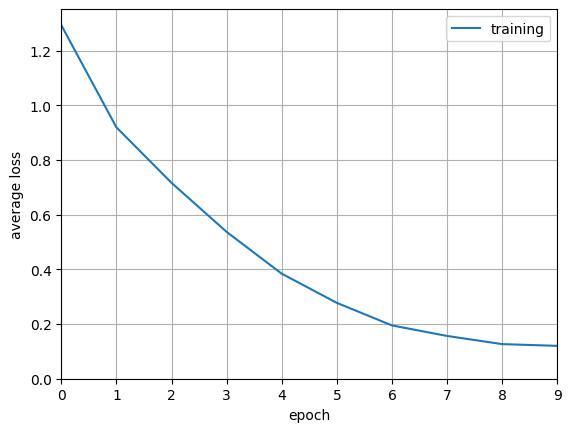

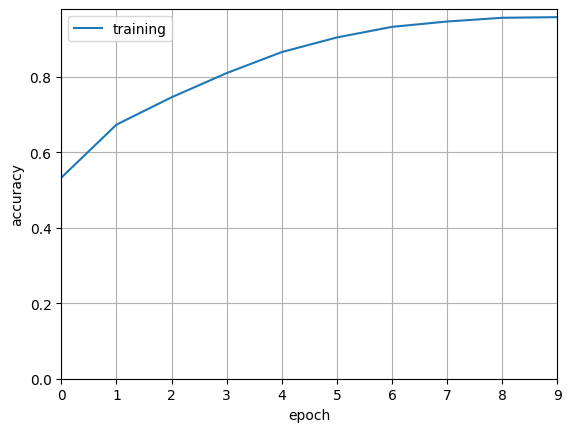

In [ ]:
# plot loss curves
plt.plot(range(len(train_losses)), train_losses, label="training")
plt.xlabel("epoch")
plt.ylabel("average loss")
plt.xlim(0, len(train_losses) - 1)
plt.ylim(0, None)
plt.legend()
plt.grid()
plt.show()

# plot accuracy curves
plt.plot(range(len(train_accs)), train_accs, label="training")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xlim(0, len(train_accs) - 1)
plt.ylim(0, None)
plt.legend()
plt.grid()
plt.show()

In [ ]:
model = ConvNet(in_channels=3, output_size=10).to(device)
model_state_dict_path = torch.load(checkpoint_path)
model.load_state_dict(model_state_dict_path["model_state_dict"])

<All keys matched successfully>

In [ ]:
def eval(model, criterion, dataloader):
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    total_instances = 0
    with torch.inference_mode():
      for i, (xb, yb) in enumerate(dataloader):
        xb = xb.to(device)
        yb = yb.to(device)
        
        logits = model(xb)
        loss = criterion(logits, yb)
        
        val_loss += loss.item()
        val_acc += (torch.argmax(logits, dim=1) == yb).sum().item()
        total_instances += len(xb)

    val_loss /= len(dataloader)
    val_acc /= total_instances
    return val_loss, val_acc

_, test_accuracy = eval(model, criterion, cifar_testloader)
print("CIFAR Conv Model Test Accuracy: {:.2f}%".format(test_accuracy))

CIFAR Conv Model Test Accuracy: 0.70%
